In [260]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [261]:
feature_id = 12
CONVERTED_DATABASE_NAME = '/home/ubuntu/UPS2_DIA_180907/UPS2_DIA_180907.sqlite'
SUMMED_REGIONS_DATABASE = '/home/ubuntu/UPS2_DIA_180907/UPS2_DIA_180907-features-{}-{}.sqlite'.format(feature_id, feature_id)

In [262]:
# get the feature's base peak id
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
feature_list_df = pd.read_sql_query("select * from feature_list where feature_id={}".format(feature_id), db_conn)
db_conn.close()
if len(feature_list_df) > 0:
    base_peak_id = feature_list_df.iloc[0].base_peak_id.astype(int)
else:
    print("Empty feature list.")

In [263]:
base_peak_id

1

In [264]:
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
feature_isotopes_df = pd.read_sql_query("select * from feature_isotopes where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [265]:
feature_isotopes_df

,feature_id,peak_id,mz_centroid,scan_centroid,summed_intensity,mz_mod
0,12,1,641.387650,433,4549739,641.387650
1,12,2,641.723649,433,2149597,641.389197
2,12,3,642.054044,434,661257,641.385141
3,12,5,642.387361,434,110358,641.384006
4,12,6,642.720481,441,7369,641.382674


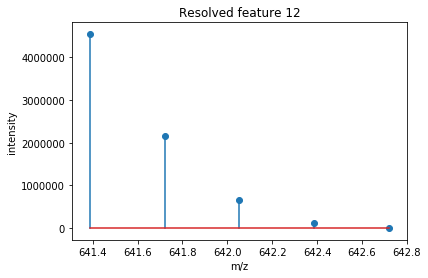

In [266]:
fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(feature_isotopes_df.mz_centroid, feature_isotopes_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Resolved feature {}'.format(feature_id))
plt.show()

Plot the raw points for each isotope in the feature

In [267]:
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
summed_ms1_region_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id={} order by peak_id".format(feature_id), db_conn)
db_conn.close()

In [268]:
summed_ms1_region_df['feature_point'] = summed_ms1_region_df['feature_id'].map(str) + '|' + summed_ms1_region_df['point_id'].map(str)

In [269]:
summed_ms1_region_df.rename(columns={"peak_id":"feature_peak_id","point_id":"feature_point_id"}, inplace=True)

In [270]:
summed_ms1_region_df.drop(['mz', 'scan', 'intensity', 'number_frames'], axis=1, inplace=True)

In [271]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,feature_peak_id,feature_point
0,12,1,1,12|1
1,12,6,1,12|6
2,12,11,1,12|11
3,12,16,1,12|16
4,12,21,1,12|21


In [272]:
# add the summed_frame_point that contributed to each feature region point
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
ms1_feature_frame_join_df = pd.read_sql_query("select * from ms1_feature_frame_join where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [273]:
ms1_feature_frame_join_df['feature_point'] = ms1_feature_frame_join_df['feature_id'].map(str) + '|' + ms1_feature_frame_join_df['feature_point_id'].map(str)
ms1_feature_frame_join_df['summed_frame_point'] = ms1_feature_frame_join_df['frame_id'].map(str) + '|' + ms1_feature_frame_join_df['frame_point_id'].map(str)

In [274]:
ms1_feature_frame_join_df.rename(columns={"frame_id":"summed_frame_id"}, inplace=True)

In [275]:
ms1_feature_frame_join_df.drop(['feature_id', 'feature_point_id', 'frame_point_id'], axis=1, inplace=True)

In [276]:
ms1_feature_frame_join_df.head()

,summed_frame_id,feature_point,summed_frame_point
0,4557,12|1,4557|25822
1,4566,12|1,4566|22865
2,4566,12|1,4566|22872
3,4567,12|1,4567|20252
4,4568,12|1,4568|18978


In [277]:
summed_ms1_region_df = pd.merge(summed_ms1_region_df, ms1_feature_frame_join_df, how='left', left_on=['feature_point'], right_on=['feature_point'])

In [278]:
summed_ms1_region_df.drop(['feature_point'], axis=1, inplace=True)

In [279]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,feature_peak_id,summed_frame_id,summed_frame_point
0,12,1,1,4557,4557|25822
1,12,1,1,4566,4566|22865
2,12,1,1,4566,4566|22872
3,12,1,1,4567,4567|20252
4,12,1,1,4568,4568|18978


In [280]:
# add the raw_frame_point that contributed to each summed frame point
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_summed_join_df = pd.read_sql_query("select * from raw_summed_join where summed_frame_id in {}".format(tuple(summed_ms1_region_df.summed_frame_id)), db_conn)
db_conn.close()

In [281]:
raw_summed_join_df.head()

,summed_frame_id,summed_point_id,raw_frame_id,raw_point_id
0,4557,1,18224,22
1,4557,1,18226,26
2,4557,1,18228,20
3,4557,1,18228,21
4,4557,1,18230,27


In [282]:
raw_summed_join_df['summed_frame_point'] = raw_summed_join_df['summed_frame_id'].map(str) + '|' + raw_summed_join_df['summed_point_id'].map(str)
raw_summed_join_df['raw_frame_point'] = raw_summed_join_df['raw_frame_id'].map(str) + '|' + raw_summed_join_df['raw_point_id'].map(str)

In [283]:
raw_summed_join_df.drop(['summed_frame_id','summed_point_id'], axis=1, inplace=True)

In [284]:
raw_summed_join_df.head()

,raw_frame_id,raw_point_id,summed_frame_point,raw_frame_point
0,18224,22,4557|1,18224|22
1,18226,26,4557|1,18226|26
2,18228,20,4557|1,18228|20
3,18228,21,4557|1,18228|21
4,18230,27,4557|1,18230|27


In [285]:
summed_ms1_region_df = pd.merge(summed_ms1_region_df, raw_summed_join_df, how='left', left_on=['summed_frame_point'], right_on=['summed_frame_point'])

In [286]:
summed_ms1_region_df.drop(['summed_frame_id','summed_frame_point'], axis=1, inplace=True)

In [287]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,feature_peak_id,raw_frame_id,raw_point_id,raw_frame_point
0,12,1,1,18224,48784,18224|48784
1,12,1,1,18226,51927,18226|51927
2,12,1,1,18228,57197,18228|57197
3,12,1,1,18230,61508,18230|61508
4,12,1,1,18260,56007,18260|56007


In [288]:
# get the raw frame point's intensity
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_frames_df = pd.read_sql_query("select * from frames where frame_id in {}".format(tuple(summed_ms1_region_df.raw_frame_id)), db_conn)
db_conn.close()

In [289]:
raw_frames_df['raw_frame_point'] = raw_frames_df['frame_id'].map(str) + '|' + raw_frames_df['point_id'].map(str)

In [290]:
summed_ms1_region_df = pd.merge(summed_ms1_region_df, raw_frames_df, how='left', left_on=['raw_frame_point'], right_on=['raw_frame_point'])

In [291]:
summed_ms1_region_df.drop(['peak_id','frame_id','raw_frame_point','point_id'], axis=1, inplace=True)

In [292]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,feature_peak_id,raw_frame_id,raw_point_id,mz,scan,intensity
0,12,1,1,18224,48784,641.380414,423,2652
1,12,1,1,18226,51927,641.384408,423,3624
2,12,1,1,18228,57197,641.384408,423,5483
3,12,1,1,18230,61508,641.384408,423,10226
4,12,1,1,18260,56007,641.392394,423,14695


In [296]:
# for each feature peak, use the raw points to find the RT and drift intensity-weighted centroids
peak_ids = summed_ms1_region_df.feature_peak_id.unique()

In [305]:
import peakutils
for peak_id in peak_ids:
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    centroid_scan = peakutils.centroid(peak_points_df.scan.astype(float), peak_points_df.intensity)
    centroid_rt = peakutils.centroid(peak_points_df.raw_frame_id.astype(float), peak_points_df.intensity)
    centroid_mz = peakutils.centroid(peak_points_df.mz.astype(float), peak_points_df.intensity)
    print("peak {}, scan {}, rt {}, mz {}".format(peak_id, centroid_scan, centroid_rt, centroid_mz))

peak 1, scan 433.579859856, rt 18259.7650832, mz 641.387650111
peak 2, scan 433.488798133, rt 18254.1274388, mz 641.723648711
peak 3, scan 434.064179283, rt 18245.0299778, mz 642.054044262
peak 4, scan 431.854206135, rt 18256.8551159, mz 641.053656464
peak 5, scan 434.616547962, rt 18240.6083293, mz 642.387360728
peak 6, scan 441.267336138, rt 18245.4957253, mz 642.72048082


In [306]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

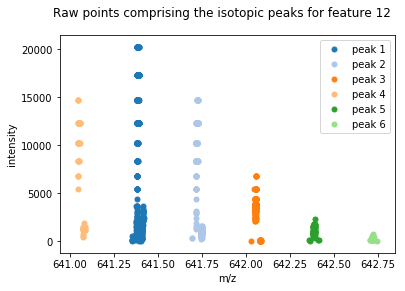

In [308]:
fig, ax = plt.subplots()
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    ax.plot(peak_points_df.mz, peak_points_df.intensity, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

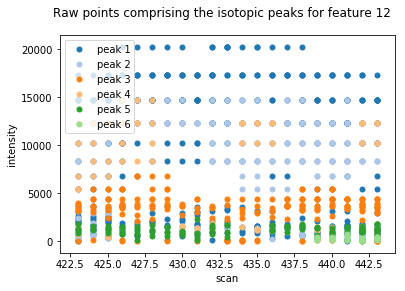

In [309]:
fig, ax = plt.subplots()
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    ax.plot(peak_points_df.scan, peak_points_df.intensity, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

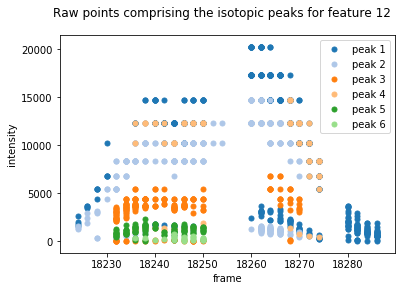

In [317]:
fig, ax = plt.subplots()
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id].copy()
    peak_points_df.sort_values(by=['raw_frame_id'], inplace=True)
    ax.plot(peak_points_df.raw_frame_id, peak_points_df.intensity, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('frame')
plt.ylabel('intensity')
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()